<a href="https://colab.research.google.com/github/alexander-toschev/mbzuai-course/blob/main/extra/bgremove_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install rembg
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00


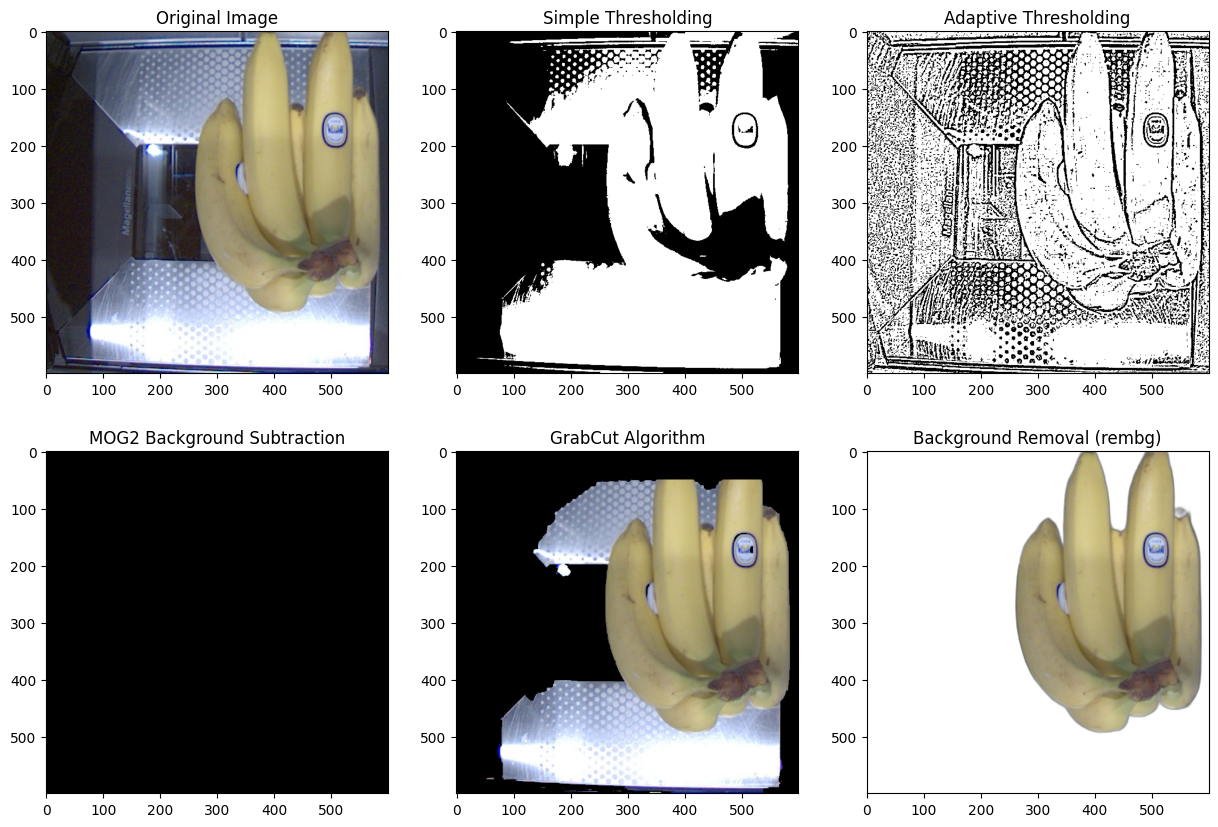

Processed images saved.
Simple Thresholding: 0.0010 seconds
Adaptive Thresholding: 0.0032 seconds
MOG2 Background Subtraction: 0.0160 seconds
GrabCut Algorithm: 4.8831 seconds
Background Removal (rembg): 2.9982 seconds


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from rembg import remove
from PIL import Image
import requests
import time

def download_image(url, filename):
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)

github_image_url_new = "https://github.com/alexander-toschev/mbzuai-course/blob/main/images/banana_new.jpg?raw=true"  # Change this to your image URL

download_image(github_image_url_new, "banana_new.jpg")

# Load image
image_path = "banana_new.jpg"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Timing dictionary
timing_results = {}

# 1. Simple Thresholding
start = time.time()
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
timing_results['Simple Thresholding'] = time.time() - start

# 2. Adaptive Thresholding
start = time.time()
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)
timing_results['Adaptive Thresholding'] = time.time() - start

# 3. Background Subtraction using MOG2
start = time.time()
fgbg = cv2.createBackgroundSubtractorMOG2()
fgmask = fgbg.apply(image)
timing_results['MOG2 Background Subtraction'] = time.time() - start

# 4. GrabCut Algorithm
start = time.time()
mask = np.zeros(image.shape[:2], np.uint8)
rect = (50, 50, image.shape[1]-50, image.shape[0]-50)
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)
cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
grabcut_result = image * mask2[:, :, np.newaxis]
timing_results['GrabCut Algorithm'] = time.time() - start

# 5. Background Removal using rembg
start = time.time()
image_pil = Image.open(image_path)
bg_removed = remove(image_pil)
bg_removed = np.array(bg_removed)
timing_results['Background Removal (rembg)'] = time.time() - start

# Display results
plt.figure(figsize=(15, 10))
plt.subplot(231), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(232), plt.imshow(thresh, cmap='gray'), plt.title('Simple Thresholding')
plt.subplot(233), plt.imshow(adaptive_thresh, cmap='gray'), plt.title('Adaptive Thresholding')
plt.subplot(234), plt.imshow(fgmask, cmap='gray'), plt.title('MOG2 Background Subtraction')
plt.subplot(235), plt.imshow(cv2.cvtColor(grabcut_result, cv2.COLOR_BGR2RGB)), plt.title('GrabCut Algorithm')
plt.subplot(236), plt.imshow(bg_removed), plt.title('Background Removal (rembg)')
plt.show()

# Save results
cv2.imwrite("/mnt/data/simple_threshold.jpg", thresh)
cv2.imwrite("/mnt/data/adaptive_threshold.jpg", adaptive_thresh)
cv2.imwrite("/mnt/data/mog2_result.jpg", fgmask)
cv2.imwrite("/mnt/data/grabcut_result.jpg", grabcut_result)
cv2.imwrite("/mnt/data/bg_removed.png", bg_removed)
print("Processed images saved.")

# Print timing results
for method, duration in timing_results.items():
    print(f"{method}: {duration:.4f} seconds")
